# Associated red out computed metrics with outcomes

We are interested to see if our logistic regression model annotating red-out can be used to measure the outcomes of the trial.

In [1]:
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score

import numpy as np
import matplotlib.pyplot as plt

import pickle
import re
import datetime
from os.path import isfile, join
import csv
import datetime

In [2]:
%load_ext rpy2.ipython

In [37]:
%%R

library(tidyverse)
library(ggplot2)
library(ggrepel)
library(magrittr)

In [4]:
plot_saving_dir = '/Users/guillaumekugener/Documents/USC/USC_docs/ml/surgical-training-project/data/'
outcomes_data_parkcity = pd.read_csv('/Users/guillaumekugener/Documents/USC/USC_docs/ml/surgical-training-project/data/parkcity-trial-annotations.txt', delimiter='\t')

In [129]:
%%R -i outcomes_data_parkcity

paper_outcomes_data <- suppressMessages(read_tsv('~/Documents/USC/USC_docs/ml/surgical-training-project/data/UPDATED_Raw Data.xlsx - Sheet1.tsv'))

paper_outcomes_data %>%
    filter(SurveyID %in% outcomes_data_parkcity$`Study.ID`) %>%
    dplyr::select(SurveyID, everything())

# A tibble: 12 x 110
   SurveyID `Respondent ID` `Collector ID` `Start Date` `End Date` `IP Address`
   <chr>              <dbl>          <dbl> <chr>        <chr>      <chr>       
 1 601                   NA             NA NA           NA         NA          
 2 602                   NA             NA NA           NA         NA          
 3 603                   NA             NA NA           NA         NA          
 4 604                   NA             NA NA           NA         NA          
 5 609                   NA             NA NA           NA         NA          
 6 610                   NA             NA NA           NA         NA          
 7 611                   NA             NA NA           NA         NA          
 8 612                   NA             NA NA           NA         NA          
 9 613                   NA             NA NA           NA         NA          
10 614                   NA             NA NA           NA         NA          
11 615             

,Respondent ID,Collector ID,Start Date,End Date,IP Address,Email Address,First name,Last name,Custom Data y,SurveyID,...,minutesinteger,realonly,simonly,realandsim,naïve,tachybl,tachyt1,tachyinter,tachyt2,tachypost
0,6.69998e+09,1.70227e+08,2018-02-16 7:41:56,2018-02-16 9:44:28,107.77.231.139,,,,,101,...,5,0,0,0,1,1,1,1,1,1
1,6.70035e+09,1.70227e+08,2018-02-16 9:49:16,2018-02-16 10:17:59,38.96.5.130,,,,,102,...,,1,0,0,0,0,1,0,0,0
2,6.70038e+09,1.70227e+08,2018-02-16 10:18:47,2018-02-16 10:36:59,38.96.5.130,,,,,103,...,13,1,0,0,0,0,1,1,1,1
3,6.70039e+09,1.70227e+08,2018-02-16 10:21:56,2018-02-16 10:47:55,38.96.5.130,,,,,104,...,6,0,0,0,1,0,0,0,0,0
4,6.70047e+09,1.70227e+08,2018-02-16 10:57:52,2018-02-16 10:59:20,38.96.5.130,,,,,105,...,6,,,,,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,,,,,,,,,,1109,...,,,,,,,,,,
157,,,,,,,,,,1110,...,,,,,,,,,,
158,,,,,,,,,,1111,...,,,,,,,,,,
159,,,,,,,,,,1112,...,,,,,,,,,,


In [116]:
%%R -i outcomes_data_parkcity,paper_outcomes_data

head(outcomes_data_parkcity)

/usr/local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "Respondent ID". Fall back to string conversion. The error is: Series can only be of one type, or None.
  % (name, str(e)))


AttributeError: 'float' object has no attribute 'encode'

In [112]:
paper_outcomes_data['SurveyID']

0       101
1       102
2       103
3       104
4       105
       ... 
156    1109
157    1110
158    1111
159    1112
160        
Name: SurveyID, Length: 161, dtype: object

In [5]:
outcomes_data_parkcity = outcomes_data_parkcity.fillna('')

In [6]:
outcomes_data_parkcity[['Folder.1', 'Video', 'Study ID', 'Trial']]

,Folder.1,Video,Study ID,Trial
0,01182019_170211,ch1_video_01,609,I
1,01182019_170211,ch1_video_01,609,II
2,01182019_170211,ch1_video_02,610,I
3,01182019_170211,ch1_video_02,610,II
4,01182019_170211,ch1_video_02,611,I
5,01182019_170211,ch1_video_03,611,II
6,01182019_170211,ch1_video_03,612,I
7,01182019_170211,ch1_video_03,612,II
8,01182019_170211,ch1_video_03,613,I
9,01182019_170211,ch1_video_03,613,II


In [7]:
# Red out files
root_dir_red_out_files = '/Users/guillaumekugener/Documents/USC/USC_docs/ml/videos/FRAMES/'
park_city_170211_v1 = pd.read_csv(join(root_dir_red_out_files, 'ParkCity2019/170211/ParkCity2019-170211-ch1_video_01/metric-redout-ParkCity2019-170211-ch1_video_01.tsv'), delimiter='\t')
park_city_170211_v2 = pd.read_csv(join(root_dir_red_out_files, 'ParkCity2019/170211/ParkCity2019-170211-ch1_video_02/metric-redout-ParkCity2019-170211-ch1_video_02.tsv'), delimiter='\t')
park_city_170211_v3 = pd.read_csv(join(root_dir_red_out_files, 'ParkCity2019/170211/ParkCity2019-170211-ch1_video_03/metric-redout-ParkCity2019-170211-ch1_video_03.tsv'), delimiter='\t')

park_city_143725_v2 = pd.read_csv(join(root_dir_red_out_files, 'ParkCity2019-143725-ch1_video_02/metric-redout-ParkCity2019-143725-ch1_video_02.tsv'), delimiter='\t')
park_city_143725_v3 = pd.read_csv(join(root_dir_red_out_files, 'ParkCity2019-143725-ch1_video_03/metric-redout-ParkCity2019-143725-ch1_video_03.tsv'), delimiter='\t')



In [8]:
for v in [('ch1_video_01', park_city_170211_v1), ('ch1_video_02', park_city_170211_v2), ('ch1_video_03', park_city_170211_v3)]:
    v[1]['video'] = v[0]
    v[1]['source'] = '01182019_170211'
    v[1]['top_source'] = 'ParkCity'
    
for v in [('ch1_video_02', park_city_143725_v2), ('ch1_video_03', park_city_143725_v3)]:
    v[1]['video'] = v[0]
    v[1]['source'] = '01182019_143725'
    v[1]['top_source'] = 'ParkCity'

video_red_out_combined = pd.concat([park_city_170211_v1, park_city_170211_v2, park_city_170211_v3, park_city_143725_v2, park_city_143725_v3], ignore_index=True, sort =False)
video_red_out_combined = video_red_out_combined.fillna('')

video_red_out_combined['index'] = [int(re.sub('\\.jpeg$', '', re.sub('^frame_(0+)', '', j))) for j in video_red_out_combined['frame']]

In [9]:
video_frame_rate = 30 # in frames per second (FPS)
max_length_of_video = 30 * 60 * 5

In [10]:
max_length_of_video + 6855

15855

In [11]:
# We estimate the start and stop frames based on the time stamps in Start and End Time columns
# We know the frame rate is 30 FPS, so we can deduce where it actually is from that

# One challenge - how do we know the exact stop frame (hemostasis could be achieved without a clear signal
# within the video...)
start_times = [datetime.datetime.strptime(i, '%H:%M:%S') for i in list(outcomes_data_parkcity['Start Time'])]
outcomes_data_parkcity['est_SF'] = [(i.hour * 60 * 60 + i.minute * 60 + i.second) * video_frame_rate for i in start_times]

end_times = [datetime.datetime.strptime(i, '%H:%M:%S') for i in list(outcomes_data_parkcity['End Time'])]
outcomes_data_parkcity['est_EF'] = [(i.hour * 60 * 60 + i.minute * 60 + i.second) * video_frame_rate for i in end_times]

In [12]:
outcomes_data_parkcity

,Folder,Folder.1,Folder.2,Video,Study ID,Trial,Start Time,End Time,TIME ON VIDEO,est_SF,est_EF
0,Park City 2019 Sim,01182019_170211,,ch1_video_01,609,I,0:03:47,0:09:03,0:05:16,6810,16290
1,Park City 2019 Sim,01182019_170211,,ch1_video_01,609,II,0:11:19,0:12:43,0:01:24,20370,22890
2,Park City 2019 Sim,01182019_170211,,ch1_video_02,610,I,0:00:20,0:01:50,0:01:30,600,3300
3,Park City 2019 Sim,01182019_170211,,ch1_video_02,610,II,0:04:24,0:06:53,0:02:29,7920,12390
4,Park City 2019 Sim,01182019_170211,,ch1_video_02,611,I,0:13:20,0:16:00,0:02:40,24000,28800
5,Park City 2019 Sim,01182019_170211,,ch1_video_03,611,II,0:00:25,0:01:40,0:01:15,750,3000
6,Park City 2019 Sim,01182019_170211,,ch1_video_03,612,I,0:06:45,0:08:00,0:01:15,12150,14400
7,Park City 2019 Sim,01182019_170211,,ch1_video_03,612,II,0:11:14,0:13:35,0:02:21,20220,24450
8,Park City 2019 Sim,01182019_170211,,ch1_video_03,613,I,0:19:33,0:24:03,0:04:30,35190,43290
9,Park City 2019 Sim,01182019_170211,,ch1_video_03,613,II,0:26:15,0:28:00,0:01:45,47250,50400


In [13]:
video_red_out_combined.loc[video_red_out_combined['red_out_prob'] > 0.5].shape

(34394, 33)

In [14]:
video_red_out_combined[(video_red_out_combined['video']=='ch1_video_02')]

,frame,range_x0-360y0-640z0,range_x0-360y640-1280z0,range_x0-360y1280-1920z0,range_x360-720y0-640z0,range_x360-720y640-1280z0,range_x360-720y1280-1920z0,range_x720-1080y0-640z0,range_x720-1080y640-1280z0,range_x720-1080y1280-1920z0,...,range_x360-720y640-1280z2,range_x360-720y1280-1920z2,range_x720-1080y0-640z2,range_x720-1080y640-1280z2,range_x720-1080y1280-1920z2,red_out_prob,video,source,top_source,index
31280,frame_00000001.jpeg,50.684397,142.669809,25.246645,88.138394,117.261697,44.910859,35.473173,101.798559,23.027812,...,145.091120,36.858338,48.144575,158.419006,23.343798,3.267279e-13,ch1_video_02,01182019_170211,ParkCity,1
31281,frame_00000002.jpeg,50.618646,141.474462,25.274271,87.415660,113.823342,44.702261,34.734965,94.376615,22.917865,...,139.694887,37.208177,47.840668,149.292036,23.528589,6.371699e-13,ch1_video_02,01182019_170211,ParkCity,2
31282,frame_00000003.jpeg,49.938411,139.567917,25.264266,85.832717,110.612661,43.996424,33.802522,90.058559,22.589670,...,135.416376,36.335773,47.220538,143.466380,23.617326,6.674010e-13,ch1_video_02,01182019_170211,ParkCity,3
31283,frame_00000004.jpeg,50.192135,139.539835,25.506463,85.739648,110.358142,43.607322,34.194878,92.795564,22.901497,...,134.855833,34.933116,47.201107,146.874974,23.983524,4.517891e-13,ch1_video_02,01182019_170211,ParkCity,4
31284,frame_00000005.jpeg,50.691458,138.697296,25.612083,86.116723,107.550621,43.433099,34.462739,88.223746,23.396528,...,129.317604,34.823498,47.154731,139.795117,24.522956,7.199189e-13,ch1_video_02,01182019_170211,ParkCity,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256347,frame_00052178.jpeg,27.034918,43.305990,7.277804,35.792938,24.980820,7.821163,9.731953,11.020078,4.225807,...,95.729887,39.043212,27.337279,51.783867,17.990373,1.360752e-28,ch1_video_02,01182019_143725,ParkCity,52178
256348,frame_00052179.jpeg,27.034874,43.141241,7.265035,35.743832,24.919423,7.798967,9.745877,11.045082,4.271155,...,95.425495,38.927582,27.362448,51.636957,18.002465,1.198202e-28,ch1_video_02,01182019_143725,ParkCity,52179
256349,frame_00052180.jpeg,27.068281,43.061367,7.261549,35.704149,24.588247,7.662747,9.757587,10.656007,4.166068,...,94.690920,38.590148,27.331202,51.005920,17.816541,1.029270e-28,ch1_video_02,01182019_143725,ParkCity,52180
256350,frame_00052181.jpeg,27.085582,43.237782,7.275990,35.744592,24.772552,7.717752,9.725881,10.946398,4.180490,...,95.521185,38.954093,27.352843,51.593880,17.927352,1.169126e-28,ch1_video_02,01182019_143725,ParkCity,52181


In [19]:
# Now, get the total red out frames for each trial and the fraction of the trial that is redded-out
red_out_metrics_by_trial = []
ranges_of_red_out = {}

only_trial_frames = None

for index, row in outcomes_data_parkcity.iterrows():
    relevant_frames = video_red_out_combined.loc[video_red_out_combined['source'] == row['Folder.1']]
    relevant_frames = relevant_frames.loc[relevant_frames['video'] == row['Video']]
    relevant_frames = relevant_frames.loc[relevant_frames['index'] >= row['est_SF']] 
    relevant_frames = relevant_frames.loc[relevant_frames['index'] <= row['est_EF']]
    
    if only_trial_frames is None:
        only_trial_frames = relevant_frames
    else:
        only_trial_frames = pd.concat([only_trial_frames, relevant_frames], ignore_index=True, sort =False)
    
    # Skip cases that don't match anything
    if (relevant_frames.shape[0] == 0):
        red_out_metrics_by_trial.append((-1, -1))
        continue
    
    # Get ranges
    key_roro = row['Video'] + '_T' + row['Trial']
    ranges_of_red_out[key_roro] = []
    range_start = -1
    prev_range = -1
    
    for ind, ro in relevant_frames.loc[relevant_frames['red_out_prob'] > 0.5].iterrows():
        if range_start == -1:
            range_start = ro['index']
            
        if ro['index'] - prev_range == 1 or prev_range == -1:
            prev_range = ro['index']
        else:
            ranges_of_red_out[key_roro].append((range_start, prev_range))
            range_start = ro['index']
            prev_range = -1
            
    ro_frames = relevant_frames.loc[relevant_frames['red_out_prob'] > 0.5]
    red_out_metrics_by_trial.append((ro_frames.shape[0], ro_frames.shape[0]/relevant_frames.shape[0]))


In [20]:
only_trial_frames.shape

(132504, 33)

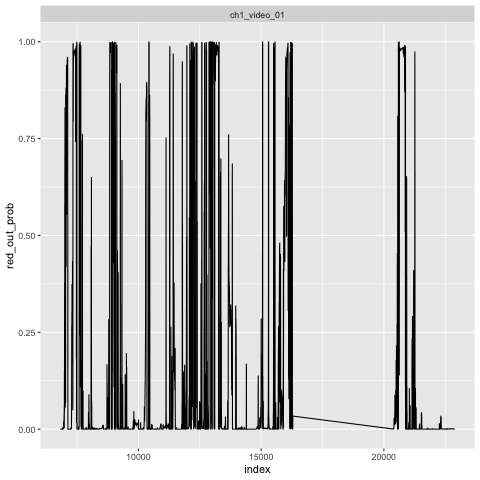

In [21]:
%%R -i only_trial_frames

ggplot(only_trial_frames %>% filter(video=='ch1_video_01'), aes(index, red_out_prob)) +
    geom_line() + 
    facet_wrap(~video)

In [22]:
outcomes_data_parkcity['total_red_out_frames'] = [i[0] for i in red_out_metrics_by_trial]
outcomes_data_parkcity['fraction_red_out_frames'] = [i[1] for i in red_out_metrics_by_trial]

In [23]:
outcomes_data_parkcity.loc[outcomes_data_parkcity['total_red_out_frames'] > 0]

,Folder,Folder.1,Folder.2,Video,Study ID,Trial,Start Time,End Time,TIME ON VIDEO,est_SF,est_EF,total_red_out_frames,fraction_red_out_frames
0,Park City 2019 Sim,01182019_170211,,ch1_video_01,609,I,0:03:47,0:09:03,0:05:16,6810,16290,1549,0.163379
1,Park City 2019 Sim,01182019_170211,,ch1_video_01,609,II,0:11:19,0:12:43,0:01:24,20370,22890,301,0.119397
2,Park City 2019 Sim,01182019_170211,,ch1_video_02,610,I,0:00:20,0:01:50,0:01:30,600,3300,114,0.042207
3,Park City 2019 Sim,01182019_170211,,ch1_video_02,610,II,0:04:24,0:06:53,0:02:29,7920,12390,427,0.095504
4,Park City 2019 Sim,01182019_170211,,ch1_video_02,611,I,0:13:20,0:16:00,0:02:40,24000,28800,675,0.140596
5,Park City 2019 Sim,01182019_170211,,ch1_video_03,611,II,0:00:25,0:01:40,0:01:15,750,3000,314,0.139494
6,Park City 2019 Sim,01182019_170211,,ch1_video_03,612,I,0:06:45,0:08:00,0:01:15,12150,14400,484,0.215016
7,Park City 2019 Sim,01182019_170211,,ch1_video_03,612,II,0:11:14,0:13:35,0:02:21,20220,24450,856,0.202316
8,Park City 2019 Sim,01182019_170211,,ch1_video_03,613,I,0:19:33,0:24:03,0:04:30,35190,43290,826,0.101963
9,Park City 2019 Sim,01182019_170211,,ch1_video_03,613,II,0:26:15,0:28:00,0:01:45,47250,50400,358,0.113615


In [46]:
%%R -i outcomes_data_parkcity,plot_saving_dir


red_out_vs_trial_time <- ggplot(outcomes_data_parkcity %>% filter(total_red_out_frames > 0), aes(est_EF-est_SF, fraction_red_out_frames, color=Trial)) +
    geom_point() +
    facet_wrap(~`Study.ID`) +
    xlab('Total frames in trial') + ylab('Fraction of frames in trial labelled as "red-out"') +
    theme_bw() 
#     theme(legend.position = c(1,0), legend.justification=c(1,0))

red_out_vs_trial_time

ggsave(red_out_vs_trial_time, filename = paste0(plot_saving_dir, 'red_out_vs_trial_time.png'), width=6, height=6)

In [25]:
trial_1_values = []
trial_2_values = []

for ind, ro in outcomes_data_parkcity.iterrows():
    if ro['Trial'] == 'I':
        trial_1_values.append((ro['total_red_out_frames'], ro['fraction_red_out_frames']))
    elif ro['Trial'] == 'II':
        trial_2_values.append((ro['total_red_out_frames'], ro['fraction_red_out_frames']))
    else:
        continue

In [86]:
all_trials_relative = []
compared_trials = {}
# We want to skip over repeats (so 601I vs. 601II is the same as 601II vs. 601I)
for i, ri in outcomes_data_parkcity.iterrows():
    for j, rj in outcomes_data_parkcity.iterrows():  
        n1 = str(ri['Study ID']) + ri['Trial']
        n2 = str(rj['Study ID']) + rj['Trial']
        
        key1 = n1 + '-' + n2
        key2 = n2 + '-' + n1
        
        # To avoid repeats
        if key1 in compared_trials:
            continue
    
        all_trials_relative.append((
            str(ri['Study ID']) + ri['Trial'] + '-' + str(rj['Study ID']) + rj['Trial'],
            ri['total_red_out_frames']/rj['total_red_out_frames'],
            ri['fraction_red_out_frames']/rj['fraction_red_out_frames']
        ))
        compared_trials[key1] = True
        compared_trials[key2] = True

In [87]:
# len(all_trials_relative)

300

In [88]:
proportional_values = [(trial_2_values[i][0]/trial_1_values[i][0], trial_2_values[i][1]/trial_1_values[i][1]) for i in range(len(trial_1_values))]

In [89]:
prop_df = pd.DataFrame({
    'trials_compared': [i[0] for i in all_trials_relative],
    'frames': [i[1] for i in all_trials_relative],
    'ro': [i[2] for i in all_trials_relative]    
})

In [90]:
prop_df

,trials_compared,frames,ro
0,609I-609I,1.000000,1.000000
1,609I-609II,5.146179,1.368370
2,609I-610I,13.587719,3.870945
3,609I-610II,3.627635,1.710701
4,609I-611I,2.294815,1.162051
...,...,...,...
295,603II-604I,0.831414,0.677797
296,603II-604II,4.000000,2.000181
297,604I-604I,1.000000,1.000000
298,604I-604II,4.811083,2.951004


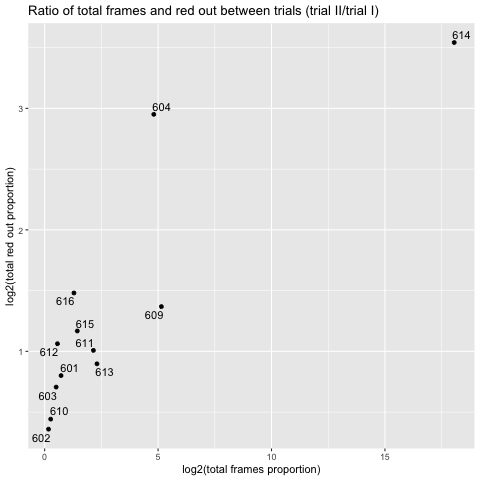

In [95]:
%%R -i prop_df,plot_saving_dir

prop_df %<>% 
    mutate(
        t1_id = gsub('I+-.*', '', trials_compared),
        t2_id = gsub('I+$', '', gsub('.*-', '', trials_compared)),
        t1_num = gsub('[0-9]+', '', gsub('-.*', '', trials_compared)),
        t2_num = gsub('[0-9]+', '', gsub('.*-', '', trials_compared))
    )

prop_df_plot <- prop_df %>% 
    filter(!((t1_id == t2_id) & (t1_num == t2_num)))

ratios_all_trials <- ggplot(prop_df_plot, aes(log2(frames), log2(ro))) +
    geom_point() +
    xlab('log2(total frames proportion)') + ylab('log2(total red out proportion)') +
    ggtitle('Ratio of total frames and red out between trials') + 
    theme_bw()

ggsave(ratios_all_trials, filename = paste0(plot_saving_dir, 'ratios_all_trials.png'), width=6, height=6)

ratios_all_trials

# If we want to just compare trial II vs. trial I proportionally
for_plot <- prop_df %>%
    filter(t1_id == t2_id, t1_num != t2_num) %>%
    group_by(t1_id) %>%
    top_n(1, t1_num)

ratios_same_id <- ggplot(for_plot, aes((frames), (ro))) +
    geom_point() +
    geom_text_repel(aes(label=t1_id)) +
    xlab('log2(total frames proportion)') + ylab('log2(total red out proportion)') +
    ggtitle('Ratio of total frames and red out between trials (trial II/trial I)')

ggsave(ratios_same_id, filename = paste0(plot_saving_dir, 'ratios_same_id.png'), width=6, height=6)

ratios_same_id